In [30]:
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit #, Aer
from qiskit import transpile, assemble
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import numpy as np
import math

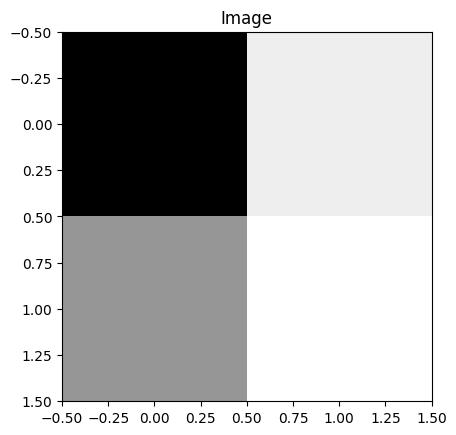

In [31]:
imagec = np.random.uniform(low=0, high=255, size=(2,2)).astype(int)
plt.imshow(imagec, cmap='gray')
plt.title('Image')
plt.show()

w_bits = int(np.ceil(math.log(imagec.shape[1],2)))
h_bits = int(np.ceil(math.log(imagec.shape[0],2)))
if not w_bits: w_bits = 1
if not h_bits: h_bits = 1

In [32]:
im_list = imagec.flatten()
ind_list = sorted(range(len(im_list)), key=lambda k:im_list[k])
max_index = max(ind_list)
#now in angles: theta = intensity, phi = coordinate
thetas = np.interp(im_list, (0, 256), (0, np.pi/2))
phis = np.interp(range(len(im_list)), (0, len(im_list)), (0, np.pi/2))

In [33]:
num_ind_bits = int(np.ceil(math.log(len(im_list),2)))
if not num_ind_bits:
    num_ind_bits = 1
num_ind_bits

2

In [34]:
thetas

array([0.28225246, 1.27013609, 0.90811663, 1.34376717])

In [35]:
def calculate_alpha(theta, qubit_levels, current_level=1):
    alpha = []
    step_size = 2**(qubit_levels - current_level)  # Number of states per group
    for i in range(0, len(theta), step_size * 2):
        sum_0 = np.sum(theta[i:i+step_size]**2)
        sum_1 = np.sum(theta[i+step_size:i+2*step_size]**2)
        alpha_angle = np.arctan(np.sqrt(sum_1 / sum_0)) if sum_0 != 0 else np.pi/2
        alpha.append(alpha_angle)
    return alpha

alpha_values_2x2 = {}
for qubit in range(1, 3):
    alpha_values_2x2[f'Level {qubit}'] =  calculate_alpha(thetas, 2, qubit)

In [36]:
alpha_values_2x2

{'Level 1': [np.float64(0.8946874767860997)],
 'Level 2': [np.float64(1.3521273809209546), np.float64(0.9764978987720102)]}

In [45]:
#seg = QuantumRegister(1)
image = QuantumRegister(num_ind_bits + 1)
cr = ClassicalRegister(image.size, "cl_reg")
qc = QuantumCircuit(image, cr)

qc.id(image)
#qc.h(seg)
qc.barrier()
qc.rx(alpha_values_2x2['Level 1'][0], image[0])
qc.barrier()
#qc.x(image[0])
qc.crx(alpha_values_2x2['Level 2'][0], image[0], image[1])
#qc.x(image[0])
qc.barrier()
qc.crx(alpha_values_2x2['Level 2'][1], image[0], image[1])
qc.barrier()

#qc.x(image[0])
#qc.x(image[1])
qc.ry(thetas[0], 2)
#qc.x(image[0])
#qc.x(image[1])
qc.barrier()

#qc.x(image[0])
qc.ry(thetas[1], 2)
#qc.x(image[0])
qc.barrier()

#qc.x(image[1])
qc.ry(thetas[2], 2)
#qc.x(image[1])
qc.barrier()

qc.ry(thetas[3], 2)
qc.barrier()

qc.measure(list(reversed(range(qc.num_qubits))), list(range(cr.size)))

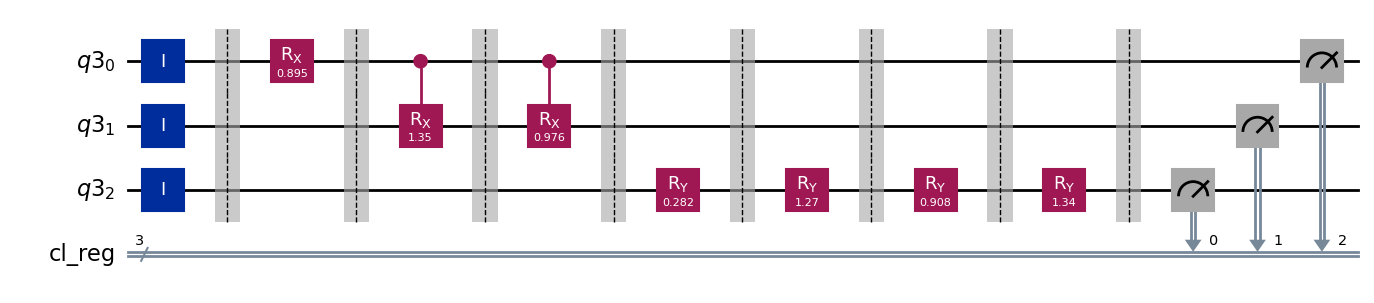

In [46]:
mpl_circuit = qc.draw(output='mpl')
mpl_circuit

In [39]:
from qiskit import transpile
from qiskit_aer import AerSimulator

# Create the AerSimulator backend
aer_sim = AerSimulator()

# Transpile the quantum circuit for the simulator
t_qc_image = transpile(qc, aer_sim)

# Run the simulation with the specified number of shots
job_oqim = aer_sim.run(t_qc_image, shots=100000)

# Get the result of the simulation
result_oqim = job_oqim.result()

# Retrieve the measurement counts
counts_oqim = result_oqim.get_counts()
counts_oqim

{'110': 433,
 '010': 3459,
 '000': 5382,
 '100': 1525,
 '001': 44279,
 '101': 12957,
 '111': 3686,
 '011': 28279}

In [44]:
classical_colors = []
for i in range(0, max_index+1):
    color_list = []
    for item in counts_oqim.items():
        key = item[0]
        amount = item[1]
        bin_coord = key[2:]
        int_coord = int(bin_coord, 2)
        if int_coord == i:
                color_list.append((bin_coord, amount))
    color_amount = 0
    print(color_list)
    for color, amount in color_list:
        if not int(color):
            color_amount= color_amount+amount
    try:
        color = np.arccos((color_amount/sum(n for _, n in color_list))**(1/2))
        classical_colors.append(color)
    except ZeroDivisionError:
        print("ZeroDivisionError")
        
    coord_amount = 0

[('0', 433), ('0', 3459), ('0', 5382), ('0', 1525)]
[('1', 44279), ('1', 12957), ('1', 3686), ('1', 28279)]
[]
ZeroDivisionError
[]
ZeroDivisionError


In [41]:
classical_colors

[np.float64(0.43985551960500713), np.float64(0.4466509747323755)]

In [42]:
imagec

array([[ 46, 207],
       [148, 219]])